In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_column', 0)

In [2]:
RANDOM_SEED = 42

In [3]:
df = pd.read_csv('LA_import_export.csv').drop('Unnamed: 0', axis=1)
# week_time = pd.to_datetime(`df.pop('Date'))
df = df.sort_values('Date')
df['Date'] = pd.to_datetime(df['Date'])
df[['predicted_hscode', 'sea_distance_km']] = df[['predicted_hscode', 'sea_distance_km']].fillna(0)

df.head()

,Date,containerType,noOfContainers,predicted_hscode,shippingWeightKg,sea_distance_km,TMAX,TMIN,TMPC,PCPN,PDSI,PHDI,ZNDX,Import or Export
0,2019-01-03,NaN,72,2709.0,14464,19638.570443,60.12,39.61,49.88,6.34,1.64,1.85,0.64,1
11,2019-01-03,NaN,816,5305.0,20443,2246.551282,60.12,39.61,49.88,6.34,1.64,1.85,0.64,1
10,2019-01-03,NaN,36,1203.0,30026,14462.919346,60.12,39.61,49.88,6.34,1.64,1.85,0.64,1
8,2019-01-03,NaN,54,4811.0,20598,2246.551282,60.12,39.61,49.88,6.34,1.64,1.85,0.64,1
7,2019-01-03,NaN,1029,1501.0,16365,2246.551282,60.12,39.61,49.88,6.34,1.64,1.85,0.64,1


In [4]:
df['predicted_hscode'].nunique()

1212

# Container Type (Import)

In [5]:
def map_container_type(code):
    if pd.isna(code):
        return np.nan
    code = str(code)
    # 45-foot high cube 9'6"
    if code.startswith('45'):
        if 'R' in code:
            return "40-foot high cube 9'6\" reefer container"
        else:
            return "40-foot high cube 9'6\" dry general usage container"
    # 42-foot (40-foot 8'6" high)
    elif code.startswith('42'):
        if 'R' in code:
            return "40-foot 8'6\" height reefer container"
        else:
            return "40-foot 8'6\" height dry general usage container"
    # 40-foot standard
    elif code.startswith('40'):
        if 'R' in code:
            return "40-foot standard reefer container"
        else:
            return "40-foot standard dry general usage container"
    # 20-foot containers
    elif code.startswith('20'):
        if 'R' in code:
            return "20-foot reefer container"
        else:
            return "20-foot dry general usage container"
    # bulk containers anywhere
    elif 'B' in code:
        return "Bulk container"
    else:
        return "Other container type"

In [6]:
df['ContainerTypeMerged'] = df['containerType'].apply(map_container_type)
df.head()

,Date,containerType,noOfContainers,predicted_hscode,shippingWeightKg,sea_distance_km,TMAX,TMIN,TMPC,PCPN,PDSI,PHDI,ZNDX,Import or Export,ContainerTypeMerged
0,2019-01-03,NaN,72,2709.0,14464,19638.570443,60.12,39.61,49.88,6.34,1.64,1.85,0.64,1,NaN
11,2019-01-03,NaN,816,5305.0,20443,2246.551282,60.12,39.61,49.88,6.34,1.64,1.85,0.64,1,NaN
10,2019-01-03,NaN,36,1203.0,30026,14462.919346,60.12,39.61,49.88,6.34,1.64,1.85,0.64,1,NaN
8,2019-01-03,NaN,54,4811.0,20598,2246.551282,60.12,39.61,49.88,6.34,1.64,1.85,0.64,1,NaN
7,2019-01-03,NaN,1029,1501.0,16365,2246.551282,60.12,39.61,49.88,6.34,1.64,1.85,0.64,1,NaN


In [7]:
df['ContainerTypeMerged'].nunique()

9

In [8]:
cols = df.columns.tolist()

# df = df.drop('containerType', axis=1)
cols_first = ['Date', 'ContainerTypeMerged']
new_order = cols_first + [col for col in cols if col not in cols_first]
df = df[new_order]
df['ContainerTypeMerged'] = df['ContainerTypeMerged'].fillna("")

df.head()

,Date,ContainerTypeMerged,containerType,noOfContainers,predicted_hscode,shippingWeightKg,sea_distance_km,TMAX,TMIN,TMPC,PCPN,PDSI,PHDI,ZNDX,Import or Export
0,2019-01-03,,NaN,72,2709.0,14464,19638.570443,60.12,39.61,49.88,6.34,1.64,1.85,0.64,1
11,2019-01-03,,NaN,816,5305.0,20443,2246.551282,60.12,39.61,49.88,6.34,1.64,1.85,0.64,1
10,2019-01-03,,NaN,36,1203.0,30026,14462.919346,60.12,39.61,49.88,6.34,1.64,1.85,0.64,1
8,2019-01-03,,NaN,54,4811.0,20598,2246.551282,60.12,39.61,49.88,6.34,1.64,1.85,0.64,1
7,2019-01-03,,NaN,1029,1501.0,16365,2246.551282,60.12,39.61,49.88,6.34,1.64,1.85,0.64,1


# Build Pipeline

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week

In [11]:
df['is_winter'] = df['Month'].isin([11,12,1,2]).astype(int)
df['is_holiday'] = df['Month'].isin([4,7,12]).astype(int)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 347247 entries, 0 to 347246
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Date                 347247 non-null  datetime64[ns]
 1   ContainerTypeMerged  347247 non-null  object        
 2   containerType        314786 non-null  object        
 3   noOfContainers       347247 non-null  int64         
 4   predicted_hscode     347247 non-null  float64       
 5   shippingWeightKg     347247 non-null  int64         
 6   sea_distance_km      347247 non-null  float64       
 7   TMAX                 347247 non-null  float64       
 8   TMIN                 347247 non-null  float64       
 9   TMPC                 347247 non-null  float64       
 10  PCPN                 347247 non-null  float64       
 11  PDSI                 347247 non-null  float64       
 12  PHDI                 347247 non-null  float64       
 13  ZNDX               

In [13]:
df2 = df.copy()

In [14]:
df2 = df2.sort_values('Date')

for lag in range(1, 5):
    df2[f'lag{lag}'] = df2['noOfContainers'].shift(lag)
df2[['lag1', 'lag2', 'lag3', 'lag4']] = df2[['lag1', 'lag2', 'lag3', 'lag4']].fillna(0)
df2.head()

,Date,ContainerTypeMerged,containerType,noOfContainers,predicted_hscode,shippingWeightKg,sea_distance_km,TMAX,TMIN,TMPC,PCPN,PDSI,PHDI,ZNDX,Import or Export,Year,Month,Week,is_winter,is_holiday,lag1,lag2,lag3,lag4
0,2019-01-03,,NaN,72,2709.0,14464,19638.570443,60.12,39.61,49.88,6.34,1.64,1.85,0.64,1,2019,1,1,1,0,0.0,0.0,0.0,0.0
5,2019-01-03,,NaN,16,8418.0,2217,8227.766084,60.12,39.61,49.88,6.34,1.64,1.85,0.64,1,2019,1,1,1,0,72.0,0.0,0.0,0.0
1,2019-01-03,,NaN,102,8473.0,195374,2246.551282,60.12,39.61,49.88,6.34,1.64,1.85,0.64,1,2019,1,1,1,0,16.0,72.0,0.0,0.0
3,2019-01-03,,NaN,5,2303.0,127069,14897.676312,60.12,39.61,49.88,6.34,1.64,1.85,0.64,1,2019,1,1,1,0,102.0,16.0,72.0,0.0
4,2019-01-03,,NaN,10,2522.0,16691,5976.553234,60.12,39.61,49.88,6.34,1.64,1.85,0.64,1,2019,1,1,1,0,5.0,102.0,16.0,72.0


In [15]:
df2[['lag1', 'lag2', 'lag3', 'lag4']].max()

lag1    246829.0
lag2    246829.0
lag3    246829.0
lag4    246829.0
dtype: float64

In [16]:
df2['noOfContainers'].max()

246829

# Filter Top Import/Export Product Types

In [17]:
hs_data = pd.read_csv('harmonized-system.csv')
hs_data.head()

,section,hscode,description,parent,level
0,I,01,Animals; live,TOTAL,2
1,I,0101,"Horses, asses, mules and hinnies; live",01,4
2,I,010121,"Horses; live, pure-bred breeding animals",0101,6
3,I,010129,"Horses; live, other than pure-bred breeding an...",0101,6
4,I,010130,Asses; live,0101,6


In [18]:
df2['predicted_hscode'] = df2['predicted_hscode'].fillna(0).astype(int).apply(lambda x: f"{x:d}")
df2['predicted_hscode'].head()

0    2709
5    8418
1    8473
3    2303
4    2522
Name: predicted_hscode, dtype: object

In [19]:
def map_hscode_description(df2, hs_data, code_col='predicted_hscode'):
    print(df2[code_col].head())
    print(type(df2[code_col]))
    print(df2[code_col].dtype)
    df2 = df2.copy()
    df2['hs_2digit'] = df2[code_col].astype(str).str[:2]
    hs_data = hs_data.copy()
    hs_data['hs_2digit'] = hs_data['hscode'].astype(str).str[:2]
    hs_lookup = hs_data[['hs_2digit', 'description']].drop_duplicates('hs_2digit')
    df2 = df2.merge(hs_lookup, on='hs_2digit', how='left')
    df2.rename(columns={'description': 'hs_description'}, inplace=True)
    return df2

In [20]:
df2 = map_hscode_description(df2, hs_data)

0    2709
5    8418
1    8473
3    2303
4    2522
Name: predicted_hscode, dtype: object
<class 'pandas.core.series.Series'>
object


In [21]:
df2 = df2.drop(['predicted_hscode', 'hs_description'], axis=1)
df2.head()

,Date,ContainerTypeMerged,containerType,noOfContainers,shippingWeightKg,sea_distance_km,TMAX,TMIN,TMPC,PCPN,PDSI,PHDI,ZNDX,Import or Export,Year,Month,Week,is_winter,is_holiday,lag1,lag2,lag3,lag4,hs_2digit
0,2019-01-03,,NaN,72,14464,19638.570443,60.12,39.61,49.88,6.34,1.64,1.85,0.64,1,2019,1,1,1,0,0.0,0.0,0.0,0.0,27
1,2019-01-03,,NaN,16,2217,8227.766084,60.12,39.61,49.88,6.34,1.64,1.85,0.64,1,2019,1,1,1,0,72.0,0.0,0.0,0.0,84
2,2019-01-03,,NaN,102,195374,2246.551282,60.12,39.61,49.88,6.34,1.64,1.85,0.64,1,2019,1,1,1,0,16.0,72.0,0.0,0.0,84
3,2019-01-03,,NaN,5,127069,14897.676312,60.12,39.61,49.88,6.34,1.64,1.85,0.64,1,2019,1,1,1,0,102.0,16.0,72.0,0.0,23
4,2019-01-03,,NaN,10,16691,5976.553234,60.12,39.61,49.88,6.34,1.64,1.85,0.64,1,2019,1,1,1,0,5.0,102.0,16.0,72.0,25


In [22]:
# df2['predicted_hscode'] = df2['predicted_hscode'].fillna(0).astype(int)

# hscode_sums_import = (
#     df2[df2['Import or Export'] == 0]
#     .groupby('predicted_hscode')['noOfContainers']
#     .sum()
#     .sort_values(ascending=False)
# )

# hscode_sums_export = (
#     df2[df2['Import or Export'] == 1]
#     .groupby('predicted_hscode')['noOfContainers']
#     .sum()
#     .sort_values(ascending=False)
# )

# top10_import = hscode_sums_import.head(10)
# top10_export = hscode_sums_export.head(10)

# print("Top 10 Import HS Codes:")
# print(top10_import)

# print("\nTop 10 Export HS Codes:")
# print(top10_export)

In [23]:
# top10_import_codes = top10_import.index.tolist()
# describable_import_codes = []

# for code in top10_import_codes:
#     desc = hs_data.loc[hs_data['hscode'] == code, 'description'].values
#     if len(desc) > 0:
#         desc_text = desc[0]
#         describable_import_codes.append(code)
#         print(f"{code}: {desc_text}")
#     else:
#         print(f"{code}: No description found")

# print("Describable codes:", describable_import_codes)

In [24]:
# top10_export_codes = top10_export.index.tolist()
# describable_export_codes = []

# for code in top10_export_codes:
#     desc = hs_data.loc[hs_data['hscode'] == code, 'description'].values
#     if len(desc) > 0:
#         desc_text = desc[0]
#         describable_export_codes.append(code)
#         print(f"{code}: {desc_text}")
#     else:
#         print(f"{code}: No description found")

# print("Describable codes:", describable_export_codes)

# Splitting Data

In [25]:
df2 = df2.drop(['Date', 'containerType'], axis=1)

In [26]:
df2.head()

,ContainerTypeMerged,noOfContainers,shippingWeightKg,sea_distance_km,TMAX,TMIN,TMPC,PCPN,PDSI,PHDI,ZNDX,Import or Export,Year,Month,Week,is_winter,is_holiday,lag1,lag2,lag3,lag4,hs_2digit
0,,72,14464,19638.570443,60.12,39.61,49.88,6.34,1.64,1.85,0.64,1,2019,1,1,1,0,0.0,0.0,0.0,0.0,27
1,,16,2217,8227.766084,60.12,39.61,49.88,6.34,1.64,1.85,0.64,1,2019,1,1,1,0,72.0,0.0,0.0,0.0,84
2,,102,195374,2246.551282,60.12,39.61,49.88,6.34,1.64,1.85,0.64,1,2019,1,1,1,0,16.0,72.0,0.0,0.0,84
3,,5,127069,14897.676312,60.12,39.61,49.88,6.34,1.64,1.85,0.64,1,2019,1,1,1,0,102.0,16.0,72.0,0.0,23
4,,10,16691,5976.553234,60.12,39.61,49.88,6.34,1.64,1.85,0.64,1,2019,1,1,1,0,5.0,102.0,16.0,72.0,25


In [27]:
num_cols = ['shippingWeightKg', 'sea_distance_km', 'Year', 'lag1', 'lag2', 'lag3', 'lag4']
cat_cols = ['ContainerTypeMerged', 'hs_2digit']

In [28]:
df2[num_cols] = np.log1p(df2[num_cols])

In [29]:
column_indices = {name: i for i, name in enumerate(df2.columns)}

n = len(df2)
train_df = df2[0:int(n*0.8)]
val_df = df2[int(n*0.8):]

num_features = df2.shape[1]

In [30]:
# num_cols = ['shippingWeightKg', 'sea_distance_km', 'Year', 'lag1', 'lag2', 'lag3', 'lag4']

# train_num = train_df[num_cols]
# val_num = val_df[num_cols]

# scaler = StandardScaler()
# train_scaled = pd.DataFrame(scaler.fit_transform(train_num),
#                             columns=train_num.columns,
#                             index=train_num.index)

# val_scaled = pd.DataFrame(scaler.transform(val_num),
#                           columns=val_num.columns,
#                           index=val_num.index)

In [31]:
cat_cols = ['ContainerTypeMerged', 'hs_2digit']

train_cat = train_df[cat_cols]
val_cat = val_df[cat_cols]

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

train_encoded = encoder.fit_transform(train_cat)
val_encoded = encoder.transform(val_cat)
encoded_col_names = encoder.get_feature_names_out(train_cat.columns)

train_encoded_df = pd.DataFrame(train_encoded, columns=encoded_col_names, index=train_cat.index)
val_encoded_df = pd.DataFrame(val_encoded, columns=encoded_col_names, index=val_cat.index)

print(train_encoded_df.head())
print(val_encoded_df.head())

   ContainerTypeMerged_  ...  hs_2digit_99
0                   1.0  ...           0.0
1                   1.0  ...           0.0
2                   1.0  ...           0.0
3                   1.0  ...           0.0
4                   1.0  ...           0.0

[5 rows x 99 columns]
        ContainerTypeMerged_  ...  hs_2digit_99
277797                   1.0  ...           0.0
277798                   1.0  ...           0.0
277799                   1.0  ...           0.0
277800                   1.0  ...           0.0
277801                   1.0  ...           0.0

[5 rows x 99 columns]


In [32]:
other_cols = list(set(train_df.columns) - set(num_cols + cat_cols))
other_cols

['Week',
 'ZNDX',
 'PCPN',
 'Import or Export',
 'is_winter',
 'TMPC',
 'is_holiday',
 'PHDI',
 'TMAX',
 'PDSI',
 'TMIN',
 'noOfContainers',
 'Month']

In [33]:
train_df = pd.concat([train_df[num_cols], train_df[other_cols], train_encoded_df], axis=1)
val_df = pd.concat([val_df[num_cols], val_df[other_cols], val_encoded_df], axis=1)

In [34]:
train_df[num_cols].head()

,shippingWeightKg,sea_distance_km,Year,lag1,lag2,lag3,lag4
0,9.579487,9.885302,7.610853,0.000000,0.000000,0.000000,0.000000
1,7.704361,9.015391,7.610853,4.290459,0.000000,0.000000,0.000000
2,12.182676,7.717597,7.610853,2.833213,4.290459,0.000000,0.000000
3,11.752493,9.609028,7.610853,4.634729,2.833213,4.290459,0.000000
4,9.722685,8.695767,7.610853,1.791759,4.634729,2.833213,4.290459


In [35]:
train_df.head()

,shippingWeightKg,sea_distance_km,Year,lag1,lag2,lag3,lag4,Week,ZNDX,PCPN,Import or Export,is_winter,TMPC,is_holiday,PHDI,TMAX,PDSI,TMIN,noOfContainers,Month,ContainerTypeMerged_,ContainerTypeMerged_20-foot dry general usage container,ContainerTypeMerged_20-foot reefer container,"ContainerTypeMerged_40-foot 8'6"" height dry general usage container","ContainerTypeMerged_40-foot 8'6"" height reefer container","ContainerTypeMerged_40-foot high cube 9'6"" dry general usage container","ContainerTypeMerged_40-foot high cube 9'6"" reefer container",ContainerTypeMerged_40-foot standard dry general usage container,ContainerTypeMerged_40-foot standard reefer container,ContainerTypeMerged_Other container type,hs_2digit_0,hs_2digit_10,hs_2digit_11,hs_2digit_12,hs_2digit_13,hs_2digit_14,hs_2digit_15,hs_2digit_16,hs_2digit_17,hs_2digit_18,...,hs_2digit_58,hs_2digit_59,hs_2digit_60,hs_2digit_61,hs_2digit_62,hs_2digit_63,hs_2digit_64,hs_2digit_65,hs_2digit_66,hs_2digit_67,hs_2digit_68,hs_2digit_69,hs_2digit_70,hs_2digit_71,hs_2digit_72,hs_2digit_73,hs_2digit_74,hs_2digit_75,hs_2digit_76,hs_2digit_78,hs_2digit_79,hs_2digit_80,hs_2digit_81,hs_2digit_82,hs_2digit_83,hs_2digit_84,hs_2digit_85,hs_2digit_86,hs_2digit_87,hs_2digit_88,hs_2digit_89,hs_2digit_90,hs_2digit_91,hs_2digit_92,hs_2digit_93,hs_2digit_94,hs_2digit_95,hs_2digit_96,hs_2digit_97,hs_2digit_99
0,9.579487,9.885302,7.610853,0.000000,0.000000,0.000000,0.000000,1,0.64,6.34,1,1,49.88,0,1.85,60.12,1.64,39.61,72,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7.704361,9.015391,7.610853,4.290459,0.000000,0.000000,0.000000,1,0.64,6.34,1,1,49.88,0,1.85,60.12,1.64,39.61,16,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12.182676,7.717597,7.610853,2.833213,4.290459,0.000000,0.000000,1,0.64,6.34,1,1,49.88,0,1.85,60.12,1.64,39.61,102,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11.752493,9.609028,7.610853,4.634729,2.833213,4.290459,0.000000,1,0.64,6.34,1,1,49.88,0,1.85,60.12,1.64,39.61,5,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9.722685,8.695767,7.610853,1.791759,4.634729,2.833213,4.290459,1,0.64,6.34,1,1,49.88,0,1.85,60.12,1.64,39.61,10,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/tmp/ipykernel_19219/383011617.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(train_df_normalised['Column'].unique(), rotation=90)


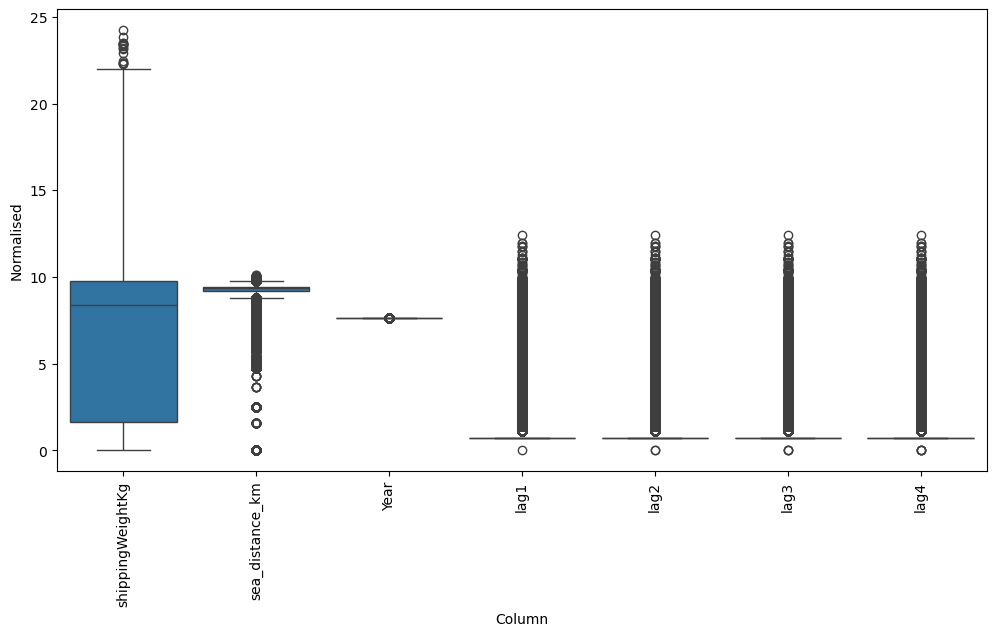

In [36]:
train_df_normalised = train_df[num_cols].copy()
train_df_normalised = train_df_normalised.melt(var_name='Column', value_name='Normalised')
plt.figure(figsize=(12, 6))
ax = sns.boxplot(x='Column', y='Normalised', data=train_df_normalised)
_ = ax.set_xticklabels(train_df_normalised['Column'].unique(), rotation=90)

In [37]:
train_df.head()

,shippingWeightKg,sea_distance_km,Year,lag1,lag2,lag3,lag4,Week,ZNDX,PCPN,Import or Export,is_winter,TMPC,is_holiday,PHDI,TMAX,PDSI,TMIN,noOfContainers,Month,ContainerTypeMerged_,ContainerTypeMerged_20-foot dry general usage container,ContainerTypeMerged_20-foot reefer container,"ContainerTypeMerged_40-foot 8'6"" height dry general usage container","ContainerTypeMerged_40-foot 8'6"" height reefer container","ContainerTypeMerged_40-foot high cube 9'6"" dry general usage container","ContainerTypeMerged_40-foot high cube 9'6"" reefer container",ContainerTypeMerged_40-foot standard dry general usage container,ContainerTypeMerged_40-foot standard reefer container,ContainerTypeMerged_Other container type,hs_2digit_0,hs_2digit_10,hs_2digit_11,hs_2digit_12,hs_2digit_13,hs_2digit_14,hs_2digit_15,hs_2digit_16,hs_2digit_17,hs_2digit_18,...,hs_2digit_58,hs_2digit_59,hs_2digit_60,hs_2digit_61,hs_2digit_62,hs_2digit_63,hs_2digit_64,hs_2digit_65,hs_2digit_66,hs_2digit_67,hs_2digit_68,hs_2digit_69,hs_2digit_70,hs_2digit_71,hs_2digit_72,hs_2digit_73,hs_2digit_74,hs_2digit_75,hs_2digit_76,hs_2digit_78,hs_2digit_79,hs_2digit_80,hs_2digit_81,hs_2digit_82,hs_2digit_83,hs_2digit_84,hs_2digit_85,hs_2digit_86,hs_2digit_87,hs_2digit_88,hs_2digit_89,hs_2digit_90,hs_2digit_91,hs_2digit_92,hs_2digit_93,hs_2digit_94,hs_2digit_95,hs_2digit_96,hs_2digit_97,hs_2digit_99
0,9.579487,9.885302,7.610853,0.000000,0.000000,0.000000,0.000000,1,0.64,6.34,1,1,49.88,0,1.85,60.12,1.64,39.61,72,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7.704361,9.015391,7.610853,4.290459,0.000000,0.000000,0.000000,1,0.64,6.34,1,1,49.88,0,1.85,60.12,1.64,39.61,16,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12.182676,7.717597,7.610853,2.833213,4.290459,0.000000,0.000000,1,0.64,6.34,1,1,49.88,0,1.85,60.12,1.64,39.61,102,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11.752493,9.609028,7.610853,4.634729,2.833213,4.290459,0.000000,1,0.64,6.34,1,1,49.88,0,1.85,60.12,1.64,39.61,5,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9.722685,8.695767,7.610853,1.791759,4.634729,2.833213,4.290459,1,0.64,6.34,1,1,49.88,0,1.85,60.12,1.64,39.61,10,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
